In [10]:
import pandas as pd
import numpy as np
from cherenkovdeconvolution import util

#p.set_printoptions(threshold=np.inf)
#df = pd.read_csv('sample.csv')
df=pd.read_csv('sample.csv', nrows=1000000)
#print(df.head(8))
#X = df[['SplineMPEDirectHitsD.dir_track_length',
#'SPEFit2_HVFitParams.nmini'                       ,
#'LineFitGeoSplit2.zenith',
#   'SplineMPE.zenith'    ,
#     'SplineMPE.azimuth' 
#       'SPEFit2GeoSplit1BayesianFitParams.nmini',
#       'SPEFit2Bayesian.x',
#       'VariousVariables.Cone_Angle',
#       'SPEFit2TimeSplit1FitParams.logl',
#       'weight_honda_h4a']]
X = df[['SPEFit2Bayesian.x',
        'SPEFit2BayesianFitParams.nmini',
        'SPEFit2_HVFitParams.nmini',
        'SplineMPE.zenith',
        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom',
        'SplineMPEDirectHitsD.dir_track_length',
        'SplineMPEDirectHitsICB.n_early_strings',
        'SplineMPEDirectHitsICB.n_late_doms',
        'SplineMPEDirectHitsICD.n_dir_strings',
        'SplineMPEDirectHitsICE.n_late_strings',
        'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value']]

Y = df['MCPrimary.energy']
#'Dustyness.n_doms_in_dust','BestTrackDirectHitsICC.n_early_strings',
binning_E = np.logspace(np.log10(Y.min()-10),
np.log10(Y.max()+100), 13)    # creating 12 bins for the energy 



#Binning overflow & underflow manually
overflow = 1e10
bins_over = np.append(binning_E,overflow)
binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

n_test = int(len(df)/10)

X_train = X.iloc[n_test:]#splitting the dataframe
Y_train = Y[n_test:]

X_test = X.iloc[:n_test]
Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true



array([2.5758e-01, 3.6933e-01, 2.1760e-01, 9.6360e-02, 3.7990e-02,
       1.3770e-02, 4.6200e-03, 1.8000e-03, 6.3000e-04, 2.4000e-04,
       5.0000e-05, 3.0000e-05])

In [20]:
from cherenkovdeconvolution import dsea
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB #worse than gaussian
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.tree import ExtraTreeClassifier # works extremly good on the data
#from sklearn.ensemble import RandomForestClassifier# super slow; about the same results as ExtraTree

f_est = dsea(X_test, X_train, Y_train, GaussianNB(), K=3)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_est, f_true)))

Chi square distance between f_est and f_true: 0.24776787086877494


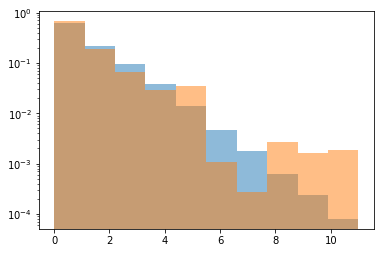

In [21]:
from matplotlib import pyplot as plt
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est, alpha = 0.5)
plt.yscale('log')
plt.show()

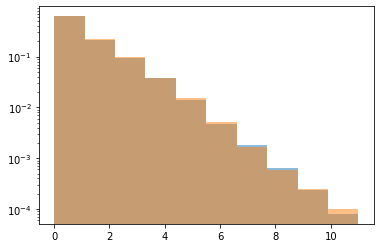

In [4]:
from cherenkovdeconvolution import dsea
from sklearn.tree import ExtraTreeClassifier

f_est2 = dsea(X_test, X_train, Y_train, ExtraTreeClassifier(), K=3) 
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est2, alpha = 0.5)
plt.yscale('log')
plt.show()

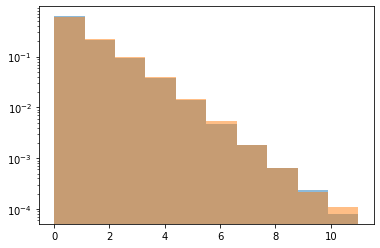

In [6]:
from cherenkovdeconvolution import dsea
from sklearn.ensemble import RandomForestClassifier
f_est3 = dsea(X_test, X_train, Y_train,RandomForestClassifier(), K=3) 
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est3, alpha = 0.5)
plt.yscale('log')
plt.show()

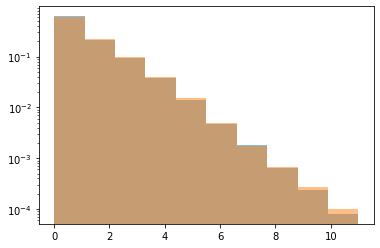

In [7]:
from cherenkovdeconvolution import dsea
from sklearn.tree import DecisionTreeClassifier
f_est4 = dsea(X_test, X_train, Y_train,DecisionTreeClassifier(), K=3) 
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est4, alpha = 0.5)
plt.yscale('log')
plt.show()

0
1
2
3


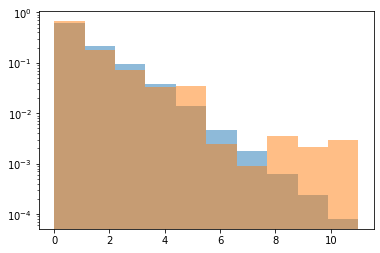

In [10]:
import cherenkovdeconvolution.stepsize as stepsize

# first of all, we set up an inspection function, which prints the step size of each iteration
def inspect_alpha(k, alpha, chi2s, f): # you can define custom inspection methods to investigate DSEA
    print(alpha)

# There are two decay rates, the first of which is comparably slow
alpha_mul = stepsize.decay_mul(0.5)
f_est_mul = dsea(X_test, X_train, Y_train, GaussianNB(), K = 3, inspect = inspect_alpha, alpha = alpha_mul)
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est_mul, alpha = 0.5)
plt.yscale('log')
plt.show()

0
1
2


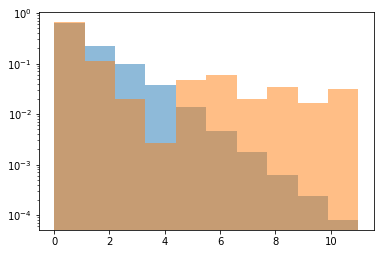

In [13]:
alpha_exp = stepsize.decay_exp(0.5, 2.0) # start with step size 2
f_est_exp = dsea(X_test, X_train, Y_train, GaussianNB(), K = 3, inspect = inspect_alpha,  alpha = alpha_exp)
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_est_exp, alpha = 0.5)
plt.yscale('log')
plt.show()

In [27]:
from cherenkovdeconvolution.discretize import TreeDiscretizer
discretizer = TreeDiscretizer(X_train, Y_train, 4)
x_data  = discretizer.discretize(X_test)
x_train = discretizer.discretize(X_train)
alpha = stepsize.alpha_adaptive_run(x_data, x_train, Y_train, tau = 0, bins_y = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

# inspect the chosen alpha values with a callback function
def inspect_alpha(f, k, a, chi2s): # this signature is mandatory. Here, f is the latest estimate.
    print('Iteration {}: alpha = {}'.format(k, a)) # print iteration number and alpha value
# deconvolve
f_est = dsea(X_test, X_train, Y_train, GaussianNB(), K = 3, alpha = alpha,inspect = inspect_alpha)
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_est, f_true)))
f_est

Iteration 0: alpha = nan
Iteration 1: alpha = 0.9988924213528076
Iteration 2: alpha = 5.663671779334335e-14
Iteration 3: alpha = 4.9999644209182255e-14
Chi square distance between f_est and f_true: 0.22142138938142164


array([0.41099392, 0.22127159, 0.16646245, 0.0853378 , 0.04667541,
       0.03840207, 0.00767099, 0.00349916, 0.00720699, 0.00459314,
       0.00350665, 0.00437982])

/home/jajaek/.local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


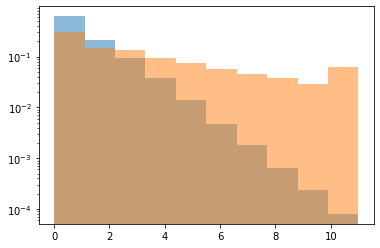

In [32]:
from sklearn.linear_model import LogisticRegression

f_logi = dsea(X_test, X_train, Y_train,LogisticRegression(), K=1) 
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_logi, alpha = 0.5)
plt.yscale('log')
plt.show()

In [7]:
from cherenkovdeconvolution import dsea
from sklearn.linear_model import LogisticRegression

f_multi = dsea(X_test, X_train, Y_train,LogisticRegression(solver='saga',multi_class='multinomial',max_iter=10000), K=3)
f_multi

array([0.05834189, 0.0796879 , 0.09175746, 0.09737599, 0.10063295,
       0.09989575, 0.0956372 , 0.09148121, 0.08473384, 0.07363908,
       0.06470635, 0.06211038])

In [8]:
from mord import LogisticSE
from cherenkovdeconvolution import dsea

f_ord=dsea(X_test, X_train, Y_train,LogisticSE(alpha=1.), K = 3)
f_ord

array([4.04024442e-03, 5.82009535e-02, 2.98888201e-01, 4.06214189e-01,
       1.78398832e-01, 4.42148696e-02, 8.21392319e-03, 1.44996711e-03,
       3.01953052e-04, 6.46942031e-05, 1.16346633e-05, 5.39056535e-07])

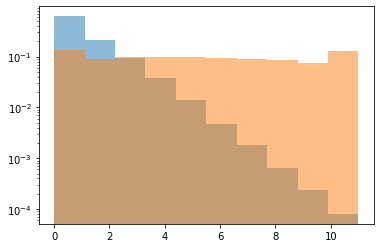

In [12]:
from matplotlib import pyplot as plt
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_multi, alpha = 0.5)
plt.yscale('log')
plt.show()


In [13]:
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_multi, f_true)))

Chi square distance between f_est and f_true: 1.8169194441082137


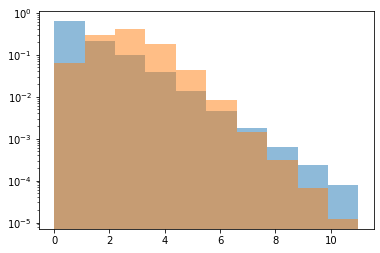

Chi square distance between f_est and f_true: 1.5687256585874765


In [15]:
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_ord, alpha = 0.5)
plt.yscale('log')
plt.show()
print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_ord, f_true)))